Problem:
The goal of this CNN is to corectly diagnosing images as either containing cancer or not.

The data is a set of training and testing .tif images with a set of accurate labels for the training set with 1 being cancer and 0 being no cancer.

All of the images are 3 channel RGB and 96x96 pixels.

EDA: Data set is very clean all thats required is importing and starting however I did want to get a feel for the dist of 1 vs 0 

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split




In [35]:
trainAll = pd.read_csv('train_labels.csv')
trainXdir = "train/"
testXdir = "test/"

train, trainTest = train_test_split(trainAll, test_size=0.2, random_state=10)


print(trainAll.head())

print("\nTraining Row Count: ",train.count())
print("\nTesting Row Count: ",trainTest.count())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Training Row Count:  id       176020
label    176020
dtype: int64

Testing Row Count:  id       44005
label    44005
dtype: int64


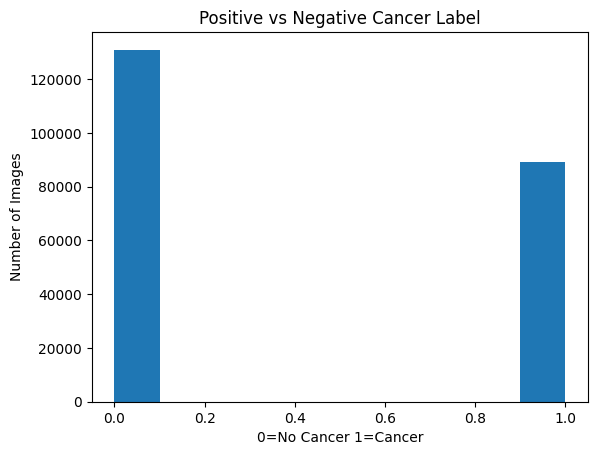

In [16]:
plt.hist(trainY["label"])
plt.title("Positive vs Negative Cancer Label")
plt.xlabel("0=No Cancer 1=Cancer")
plt.ylabel("Number of Images")
plt.show()

Model Architecture: 
The reason I went with this is it seems to be a mostly simple architecture to get going with 2D image verification, and mirrored some of the examples given in class in layer design.

In [82]:
filterFactor = 64

model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(filterFactor, (3,3), activation = "relu", input_shape=(96,96,3)),
    MaxPooling2D(2,2),
    Conv2D(filterFactor*2, (3,3), activation = "relu", input_shape=(96,96,3)),
    MaxPooling2D(2,2),
    Conv2D(filterFactor*4, (3,3), activation = "relu", input_shape=(96,96,3)),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation = "sigmoid") #needed to flatten everything to a final answer
    
])

model.summary()

C:\Users\Cale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │    26,214,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,585,729 (101.42 MB)

 Trainable params: 26,585,729 (101.42 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
train["label"] = train["label"].astype(str)
trainTest["label"] = trainTest["label"].astype(str)

train["file"] = train["id"] + ".tif"
trainTest["file"] = trainTest["id"] + ".tif"

#make image generator to train CNN on
trainImageData = ImageDataGenerator().flow_from_dataframe(
    dataframe=train,
    directory=trainXdir,
    x_col='file',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

testImageData = ImageDataGenerator().flow_from_dataframe(
    dataframe=trainTest,
    directory=trainXdir,
    x_col='file',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [83]:
#compile the model using optimizer and loss functions discussed in class
model.compile(optimizer='Adagrad', loss='BinaryCrossentropy', metrics=['accuracy'])

In [84]:
out = model.fit(trainImageData, epochs=5, validation_data=testImageData)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1710s 311ms/step - accuracy: 0.7832 - loss: 1.5749 - val_accuracy: 0.8180 - val_loss: 0.4064
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1346s 245ms/step - accuracy: 0.8204 - loss: 0.4064 - val_accuracy: 0.8308 - val_loss: 0.3797
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1198s 218ms/step - accuracy: 0.8352 - loss: 0.3765 - val_accuracy: 0.7937 - val_loss: 0.4461
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1199s 218ms/step - accuracy: 0.8517 - loss: 0.3438 - val_accuracy: 0.8454 - val_loss: 0.3507
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1197s 218ms/step - accuracy: 0.8625 - loss: 0.3195 - val_accuracy: 0.8370 - val_loss: 0.3783


Conclusion:
Getting up to 83.7% accuracy on the validation section of the test data set with a relatively simple model and low number of filters is very impressive and shows the strength of CNN models very well.

I was at a higher accuracy in epoch 4 so I may have over trained a bit for the ammount of data I had and given more time would definitely tweak the ammount of training and number and types of filters to try and get a higher score.

Make the submission for the kaggle:

In [85]:
import os 


submissionImageData = ImageDataGenerator().flow_from_dataframe(
    dataframe=pd.DataFrame({'file': os.listdir(testXdir)}),
    directory=testXdir,
    x_col='file',
    y_col='',
    target_size=(96, 96),
    batch_size=32,
    class_mode=None
)

Found 57458 validated image filenames.


In [86]:

predictions = model.predict(submissionImageData, steps=submissionImageData.samples)

    1/57458 ━━━━━━━━━━━━━━━━━━━━ 1:46:23 111ms/step

C:\Users\Cale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 274s 5ms/step     


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [88]:
files = submissionImageData.filenames
ids = [name.split(".")[0] for name in files]

labels = (predictions > 0.5).astype(int).reshape(-1)

df = pd.DataFrame({"id":ids, "label":labels})

df.to_csv('submission.csv', index=False)